In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import acovf
from scipy.optimize import curve_fit

### Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

```cpp
if( property == "POTENTIAL_ENERGY" ){
    //code...
    _vtail = 8. * M_PI * _rho * (1/(9*pow(_r_cut,9)) - 1/(3*pow(_r_cut,3)));
}

else if( property == "PRESSURE" ){
    //code...    
     _ptail = 32. * M_PI * _rho *(1/(9*pow(_r_cut,9)) - 1/(6*pow(_r_cut,3))); 
}
```

### Exercise 07.2

Use the NSL simulator code to print out **instantaneous** values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo $(N,V,T)$ and Molecular Dynamics $(N,V,E)$ simulations of $M=5\times 10^5$ MC steps or MD time steps (where, for MC, the Metropolis acceptance ratio should be fixed approximately to 50% by changing the value of $dt$ that, in the MC case, represent the amplitude of the step in each direction) in the following thermodynamic conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r^\star_c = 2.5$, for MD $dt^\star=0.001$)

Equilibration is needed both with MC and with MD. With MD, you will observe that starting from a perfect crystalline configuration the temperature, $T$, will not conserve its value. Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$.
Perform your MC and MD simulations by re-starting after such equilibration time.

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks.Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

# (N,V,E)


This is the input file I used for the configuration
```txt
SIMULATION_TYPE        0    
RESTART                0
TEMP                   2
NPART                  108
RHO                    0.8
R_CUT                  2.5
DELTA                  0.001
NBLOCKS                5000
NSTEPS                 1

ENDINPUT
```

# Grafico di temperature.dat e potential_energy.dat

/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/1990221279.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, comment="#", header=None)


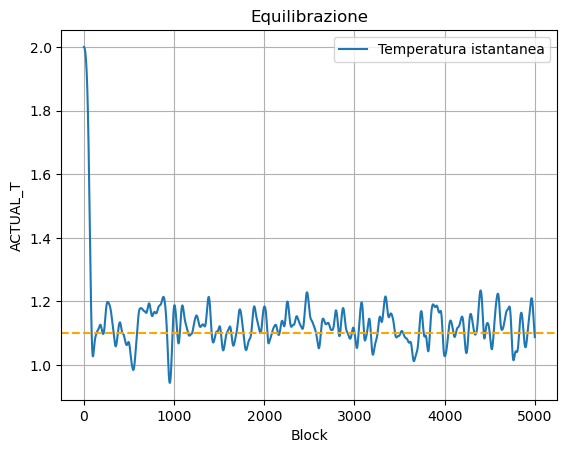

In [97]:
filename = "/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVE/temperature.dat"

df = pd.read_csv(filename, delim_whitespace=True, comment="#", header=None)
df.columns = ["Block", "ACTUAL_T", "T_AVE", "ERROR"]

df_subset = df.iloc[:5000]

plt.plot(df_subset["Block"], df_subset["ACTUAL_T"], label="Temperatura istantanea")

plt.xlabel("Block")
plt.ylabel("ACTUAL_T")
plt.title("Equilibrazione")
plt.axhline(1.1, linestyle='--', color='orange')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/1372291474.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVE/potential_energy.dat',


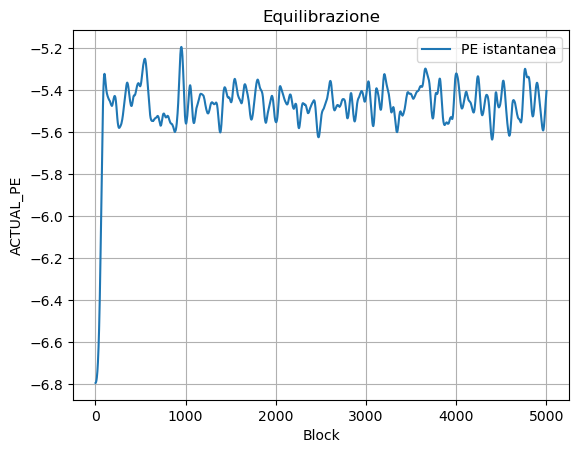

In [98]:
# Leggi il file (saltando la prima riga con intestazioni/commenti)
df = pd.read_csv('/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVE/potential_energy.dat',
                 delim_whitespace=True, comment="#", header=None)

df.columns = ["Block", "ACTUAL_PE", "PE_AVE", "ERROR"]

# Limitare ai primi 5000 blocchi
df_subset = df.iloc[:5000]

# Grafico senza barre di errore
plt.plot(df_subset["Block"], df_subset["ACTUAL_PE"], label="PE istantanea")

plt.xlabel("Block")
plt.ylabel("ACTUAL_PE")
plt.title("Equilibrazione")
plt.legend()
plt.grid(True)
plt.show()

Per fare la parte successiva dell'esercizio occorre utilizzare la flag restart per ricominciare con l'ultima configurazione salvata, partendo quindi da una condizione all'equilibrio.
```txt
SIMULATION_TYPE        0    
RESTART                1
TEMP                   2
NPART                  108
RHO                    0.8
R_CUT                  2.5
DELTA                  0.001
NBLOCKS                500000
NSTEPS                 1

ENDINPUT
```

I dati generati sono stati copiati in una cartella OUTPUT_NVE. Ora con uno script python faccio il calcolo dell'autocorrelazione. 

# Calcolo della autocorrelazione


In [87]:
read_NVE = pd.read_csv('NSL_SIMULATOR/OUTPUT_NVE/potential_energy.dat', header=None, skiprows=1, delim_whitespace=True)
y = read_NVE.iloc[:, 1]

def acf_mine(x, nlags):
    avf = acovf(x, fft=True)
    acf_values = avf[: nlags + 1] / avf[0]
    return acf_values
    
chi = acf_mine(y, 1000)


/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/4173464422.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  read_NVE = pd.read_csv('NSL_SIMULATOR/OUTPUT_NVE/potential_energy.dat', header=None, skiprows=1, delim_whitespace=True)


# Grafico della autocorrelazione

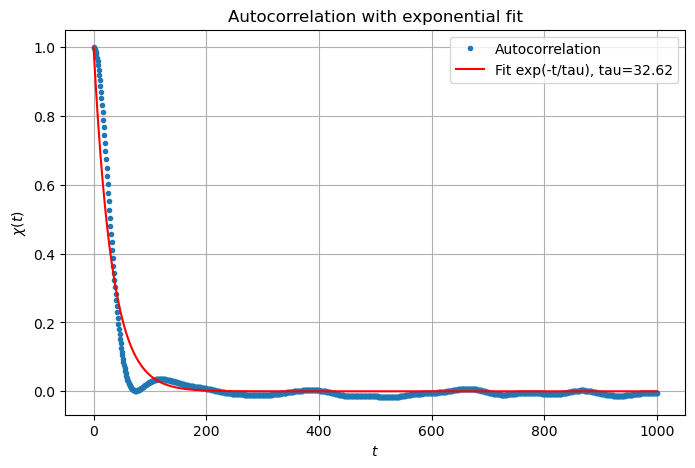

Tau stimato = 32.620


In [88]:
def exp_decay(lag, tau):
    return np.exp(-lag/tau)

# x = lag (da 0 a len(chi)-1)
x1 = np.arange(len(chi))

# escludo lag=0 perché lì chi=1 esatto (non informativo per il fit)
x_fit = x1[1:]
y_fit = chi[1:]

# fit
popt, pcov = curve_fit(exp_decay, x_fit, y_fit, p0=[50])  # p0 = guess iniziale per tau
tau = popt[0]

# curva fitted
chi_fit = exp_decay(x1, tau)

# plot
plt.figure(figsize=(8,5))
plt.plot(x1, chi, 'o', markersize=3, label='Autocorrelation')
plt.plot(x1, chi_fit, 'r-', label=f'Fit exp(-t/tau), tau={tau:.2f}')
plt.xlabel('$t$')
plt.ylabel('$\\chi(t)$')
plt.title('Autocorrelation with exponential fit')
plt.legend()
plt.grid()
plt.show()

print(f"Tau stimato = {tau:.3f}")


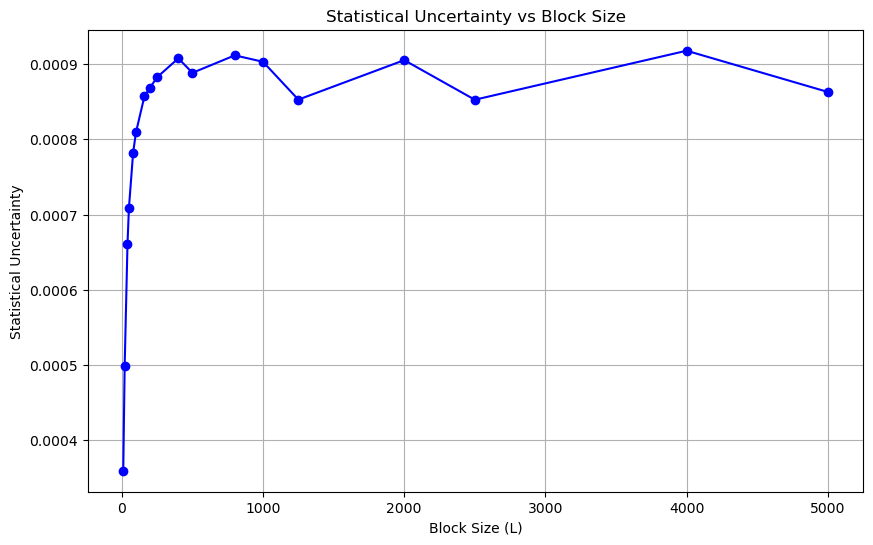

In [89]:
# Define the data blocking technique
def data_blocking(data, block_sizes):
    M = len(data)  # Total number of data points
    uncertainties = []

    for L in block_sizes:
        if M % L != 0:
            continue  # Skip block sizes that don't divide the data evenly

        N = M // L  # Number of blocks
        block_means = []

        # Calculate the mean for each block
        for i in range(N):
            block = data[i * L:(i + 1) * L]
            block_means.append(block.mean())

        # Calculate the statistical uncertainty
        block_means = np.array(block_means)
        uncertainty = np.sqrt(block_means.var(ddof=1) / N)
        uncertainties.append((L, uncertainty))

    return uncertainties

# Extract the data (U/N) from the y series
data = y.values

# Define block sizes from L=10 to L=5000
block_sizes = np.arange(10, 5001, 10)

# Perform data blocking
results = data_blocking(data, block_sizes)

# Extract block sizes and uncertainties
block_sizes, uncertainties = zip(*results)

# Plot the statistical uncertainties as a function of block size
plt.figure(figsize=(10, 6))
plt.plot(block_sizes, uncertainties, marker='o', linestyle='-', color='blue')
plt.xlabel('Block Size (L)')
plt.ylabel('Statistical Uncertainty')
plt.title('Statistical Uncertainty vs Block Size')
plt.grid()
plt.show()

# Observation:
# After the block size becomes large enough, the statistical uncertainties stabilize.
# This indicates that the data blocking technique effectively reduces noise and provides a reliable estimate of the uncertainty.

When the block size becomes sufficiently large, the statistical uncertainty reaches a plateau.


# (N,V,T)
```txt
SIMULATION_TYPE        1    
RESTART                0
TEMP                   1.1
NPART                  108
RHO                    0.8
R_CUT                  2.5
DELTA                  0.1
NBLOCKS                5000
NSTEPS                 1

ENDINPUT
```

# Equilibrazione

/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/2264280031.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  temperature_data = pd.read_csv('NSL_SIMULATOR/OUTPUT/acceptance.dat', skiprows= 1,header=None, delim_whitespace=True)


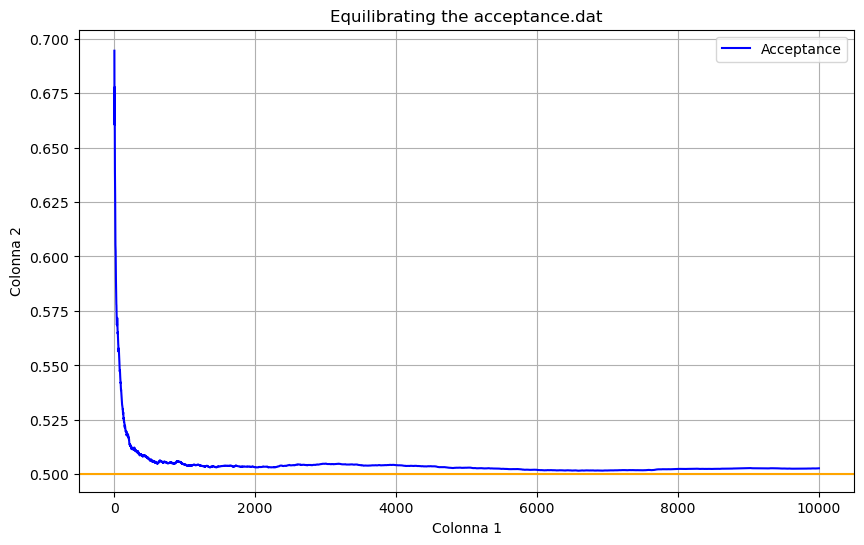

In [ ]:
# Caricamento del file temperature.dat
temperature_data = pd.read_csv('NSL_SIMULATOR/OUTPUT_NVT/acceptance.dat', skiprows= 1,header=None, delim_whitespace=True)

# Estrazione delle colonne
x_temp = temperature_data.iloc[:10000, 0]  # Prima colonna
y_temp = temperature_data.iloc[:10000, 1]  # Seconda colonna

# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.plot(x_temp, y_temp, linestyle='-', marker='', color='blue', label='Acceptance')
plt.xlabel('Colonna 1')
plt.ylabel('Colonna 2')
plt.title('Equilibrating the acceptance')
plt.legend()
plt.axhline(0.5, color = 'orange')
plt.grid()
plt.show()

/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/2000802185.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  temperature_data = pd.read_csv('NSL_SIMULATOR/OUTPUT/potential_energy.dat', skiprows= 1,header=None, delim_whitespace=True)


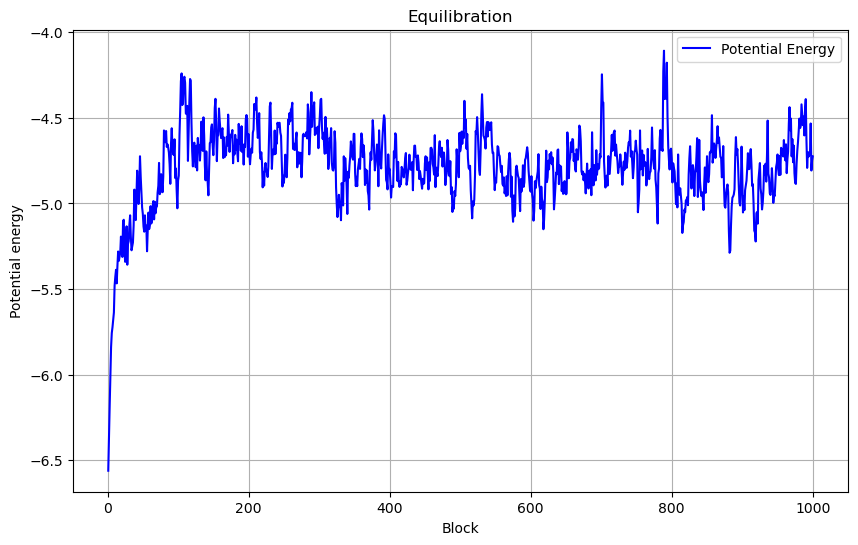

In [ ]:
# Caricamento del file temperature.dat
temperature_data = pd.read_csv('NSL_SIMULATOR/OUTPUT_NVT/potential_energy.dat', skiprows= 1,header=None, delim_whitespace=True)

# Estrazione delle colonne
x_temp = temperature_data.iloc[:1000, 0]  # Prima colonna
y_temp = temperature_data.iloc[:1000, 1]  # Seconda colonna

# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.plot(x_temp, y_temp, linestyle='-', marker='', color='blue', label='Potential Energy')
plt.xlabel('Block')
plt.ylabel('Potential energy')
plt.title('Equilibration')
plt.legend()
plt.grid()
plt.show()

## Autocorrelazione MC

The input file is like that:
```txt
SIMULATION_TYPE        1    
RESTART                1
TEMP                   1.1
NPART                  108
RHO                    0.8
R_CUT                  2.5
DELTA                  0.12
NBLOCKS                500000
NSTEPS                 1

ENDINPUT
```

In [ ]:
read_MC = pd.read_csv('/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVT/potential_energy.dat', header=None, skiprows=1, delim_whitespace=True)
y_MC = read_MC.iloc[:, 1]

def acf_mine(x, nlags):
    avf = acovf(x, fft=True)
    acf_values = avf[: nlags + 1] / avf[0]
    return acf_values
    
chi_MC = acf_mine(y_MC, 500)

/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/1339950698.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  read_MC = pd.read_csv('/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT/potential_energy.dat', header=None, skiprows=1, delim_whitespace=True)


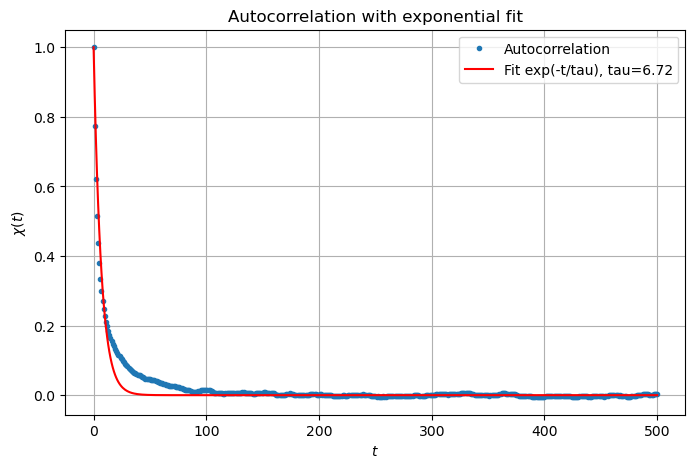

In [119]:
def exp_decay(lag, tau):
    return np.exp(-lag/tau)

x1 = np.arange(len(chi_MC))

x_fit = x1[1:]
y_fit = chi_MC[1:]

# fit
popt, pcov = curve_fit(exp_decay, x_fit, y_fit, p0=[50])  # p0 = guess iniziale per tau
tau = popt[0]

# curva fitted
chi_fit = exp_decay(x1, tau)

# plot
plt.figure(figsize=(8,5))
plt.plot(x1, chi_MC, 'o', markersize=3, label='Autocorrelation')
plt.plot(x1, chi_fit, 'r-', label=f'Fit exp(-t/tau), tau={tau:.2f}')
plt.xlabel('$t$')
plt.ylabel('$\\chi(t)$')
plt.title('Autocorrelation with exponential fit')
plt.legend()
plt.grid()
plt.show()

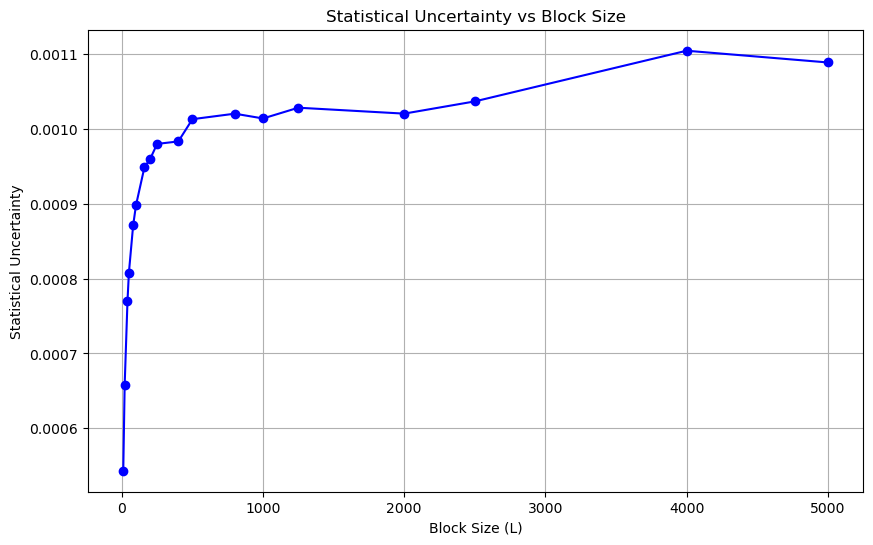

In [120]:
# Extract the data (U/N) from the y series
data_MC = y_MC.values

# Define block sizes from L=10 to L=5000
block_sizes = np.arange(10, 5001, 10)

# Perform data blocking
results = data_blocking(data_MC, block_sizes)

# Extract block sizes and uncertainties
block_sizes, uncertainties = zip(*results)

# Plot the statistical uncertainties as a function of block size
plt.figure(figsize=(10, 6))
plt.plot(block_sizes, uncertainties, marker='o', linestyle='-', color='blue')
plt.xlabel('Block Size (L)')
plt.ylabel('Statistical Uncertainty')
plt.title('Statistical Uncertainty vs Block Size')
plt.grid()
plt.show()

# 7.3 - gofr

The radial distribution function (RDF) is a structural quantity that measures the probability of finding a pair of atoms separated by a distance r, relative to what would be expected in a completely random distribution at the same density. To compute it, we count the number of particle pairs separated by distance 
r and record these counts in a histogram. This histogram is then normalized by the volume of the spherical shell at distance r and by the total number of particles in the system.

Per implementare questo calcolo ho apportato le seguenti aggiunte al codice nella funzione `System::measure()`:
```cpp
if(_measure_gofr)
  for (int i=0; i<_n_bins; i++)
    _measurement(_index_gofr + i) /= ( _rho * _npart * (4./3.) * M_PI * (pow(_bin_size * (i + 1), 3) - pow(_bin_size * i, 3)) ) ;
```
and in `System::averages` as follows:
```cpp
if (_measure_gofr and blk == _nblocks and _sim_type!=2 and _sim_type!=3){
		coutf.open("../OUTPUT/gofr.dat",ios::app);
		for(int i=0; i<_n_bins; i++){
			average	= _average(_index_gofr + i);
			sum_average = _global_av(_index_gofr + i);
			sum_ave2 = _global_av2(_index_gofr + i);
			coutf << setw(12) << i*_bin_size
					<< setw(12) << sum_average/double(blk)
					<< setw(12) << this->error(sum_average, sum_ave2, blk) << endl;
		}
		coutf.close();
	}
```


/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/3994512481.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  gofr_data = pd.read_csv('NSL_SIMULATOR/OUTPUT/gofr.dat', skiprows=1, header=None, delim_whitespace=True)


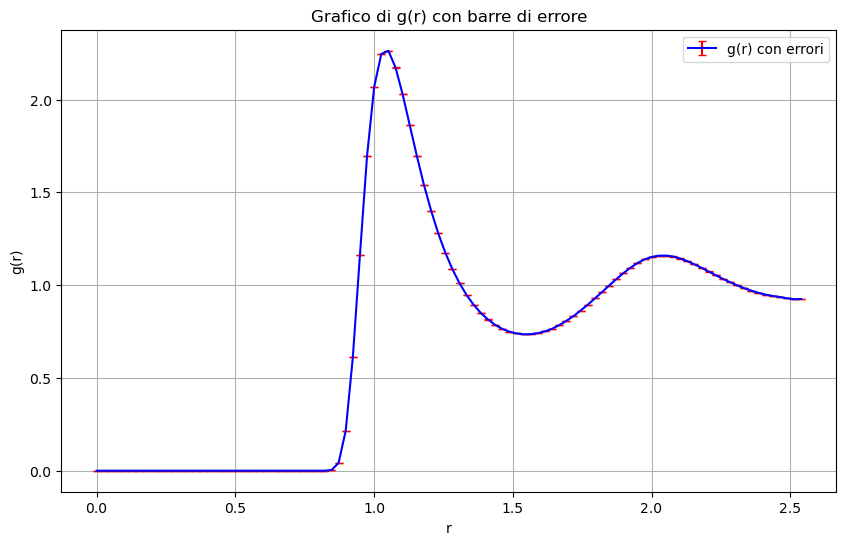

In [ ]:
# Caricamento del file gofr.dat
gofr_data = pd.read_csv('NSL_SIMULATOR/OUTPUT_NVT/gofr.dat', skiprows=1, header=None, delim_whitespace=True)

# Estrazione delle colonne
x_gofr = gofr_data.iloc[:, 0]  # Prima colonna (r)
y_gofr = gofr_data.iloc[:, 1]  # Seconda colonna (g(r))
y_err = gofr_data.iloc[:, 2]   # Terza colonna (errori)

# Creazione del grafico con barre di errore
plt.figure(figsize=(10, 6))
plt.errorbar(x_gofr, y_gofr, yerr=y_err, linestyle='-', color='blue', ecolor='red', capsize=3, label='g(r) con errori')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Grafico di g(r) con barre di errore')
plt.legend()
plt.grid()
plt.show()

## Esercizio 7.4
By means of your upgraded NSL simulator code, equilibrate and perform MC NVT and MD NVE simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... and compare your MC results for these quantities with those obtained via MD NVE simulations in similar thermodynamic conditions.

### Potential Energy

/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/2513530035.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nve = pd.read_csv(file_nve, delim_whitespace=True, comment="#", header=None)
/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/2513530035.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nvt = pd.read_csv(file_nvt, delim_whitespace=True, comment="#", header=None)


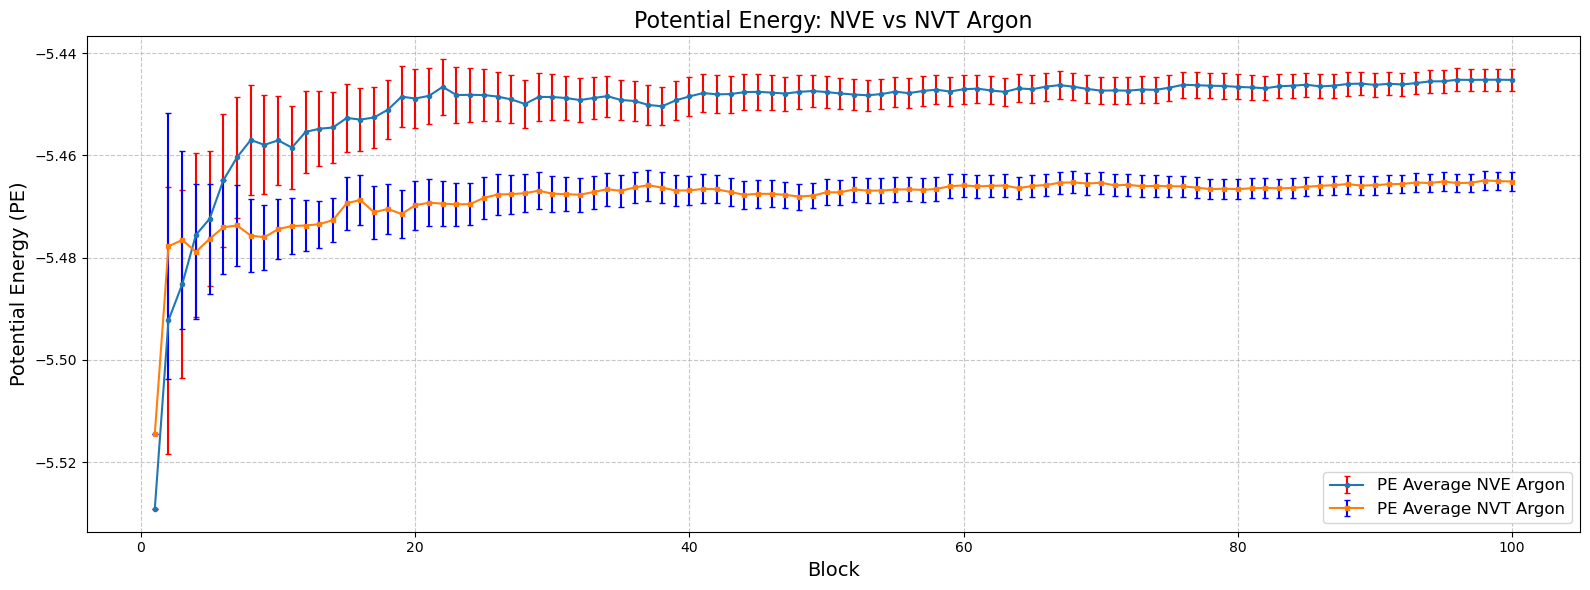

In [132]:
# File 1: NVE
file_nve = "/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVEARGON/potential_energy.dat"
df_nve = pd.read_csv(file_nve, delim_whitespace=True, comment="#", header=None)
df_nve.columns = ["Block", "ACTUAL_PE", "PE_AVE", "ERROR"]

# File 2: NVT Argon
file_nvt = "/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVTARGON/potential_energy.dat"
df_nvt = pd.read_csv(file_nvt, delim_whitespace=True, comment="#", header=None)
df_nvt.columns = ["Block", "ACTUAL_PE", "PE_AVE", "ERROR"]

# Grafico con barre di errore per entrambi i dataset
plt.figure(figsize=(16,6))

plt.errorbar(df_nve["Block"], df_nve["PE_AVE"], yerr=df_nve["ERROR"],
             fmt='-o', markersize=3, linewidth=1.5, ecolor='red', capsize=2, label="PE Average NVE Argon")

plt.errorbar(df_nvt["Block"], df_nvt["PE_AVE"], yerr=df_nvt["ERROR"],
             fmt='-s', markersize=3, linewidth=1.5, ecolor='blue', capsize=2, label="PE Average NVT Argon")

plt.xlabel("Block", fontsize=14)
plt.ylabel("Potential Energy (PE)", fontsize=14)
plt.title("Potential Energy: NVE vs NVT Argon", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Pression

/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/3815001634.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nve = pd.read_csv(file_nve, delim_whitespace=True, comment="#", header=None)
/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/3815001634.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nvt = pd.read_csv(file_nvt, delim_whitespace=True, comment="#", header=None)


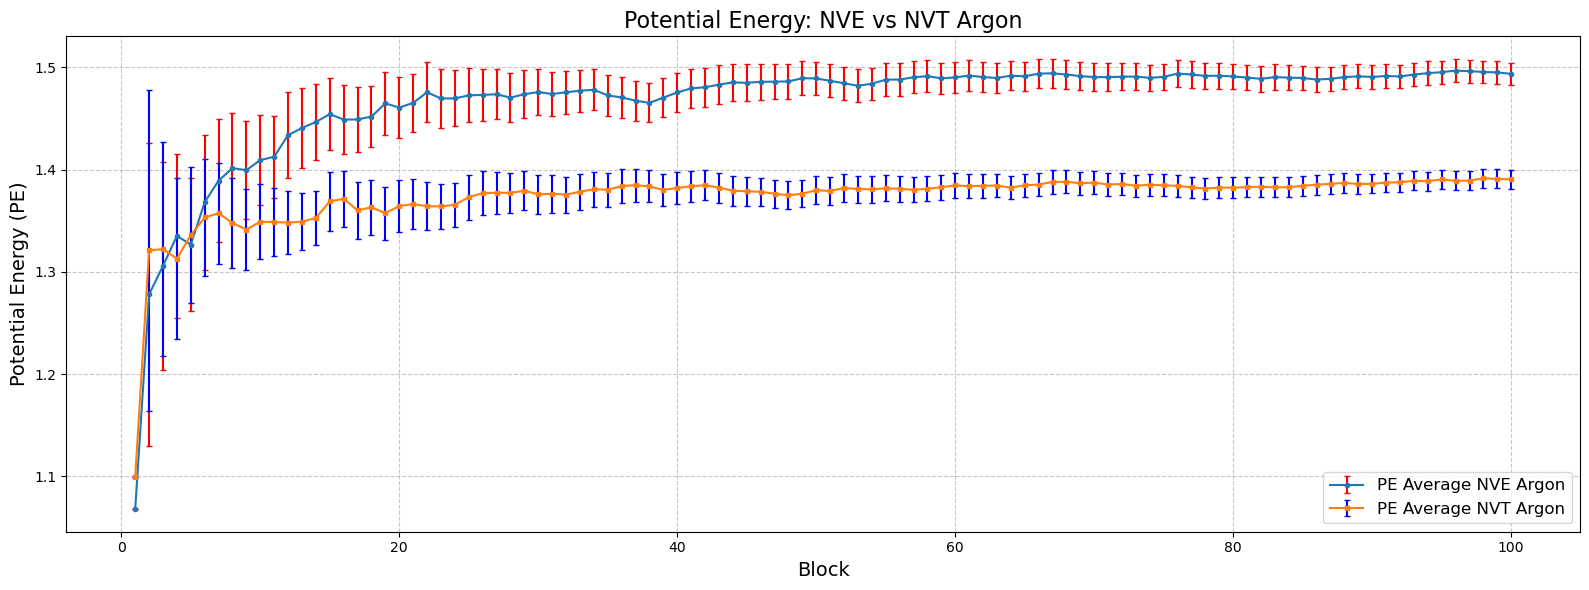

In [134]:
# File 1: NVE
file_nve = "/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVEARGON/pressure.dat"
df_nve = pd.read_csv(file_nve, delim_whitespace=True, comment="#", header=None)
df_nve.columns = ["Block", "ACTUAL_PE", "PE_AVE", "ERROR"]

# File 2: NVT Argon
file_nvt = "/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVTARGON/pressure.dat"
df_nvt = pd.read_csv(file_nvt, delim_whitespace=True, comment="#", header=None)
df_nvt.columns = ["Block", "ACTUAL_PE", "PE_AVE", "ERROR"]

# Grafico con barre di errore per entrambi i dataset
plt.figure(figsize=(16,6))

plt.errorbar(df_nve["Block"], df_nve["PE_AVE"], yerr=df_nve["ERROR"],
             fmt='-o', markersize=3, linewidth=1.5, ecolor='red', capsize=2, label="PE Average NVE Argon")

plt.errorbar(df_nvt["Block"], df_nvt["PE_AVE"], yerr=df_nvt["ERROR"],
             fmt='-s', markersize=3, linewidth=1.5, ecolor='blue', capsize=2, label="PE Average NVT Argon")

plt.xlabel("Block", fontsize=14)
plt.ylabel("Potential Energy (PE)", fontsize=14)
plt.title("Potential Energy: NVE vs NVT Argon", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Radial distribution


/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/3201382075.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nve = pd.read_csv(file_nve, delim_whitespace=True, comment="#", header=None)
/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/3201382075.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nvt = pd.read_csv(file_nvt, delim_whitespace=True, comment="#", header=None)


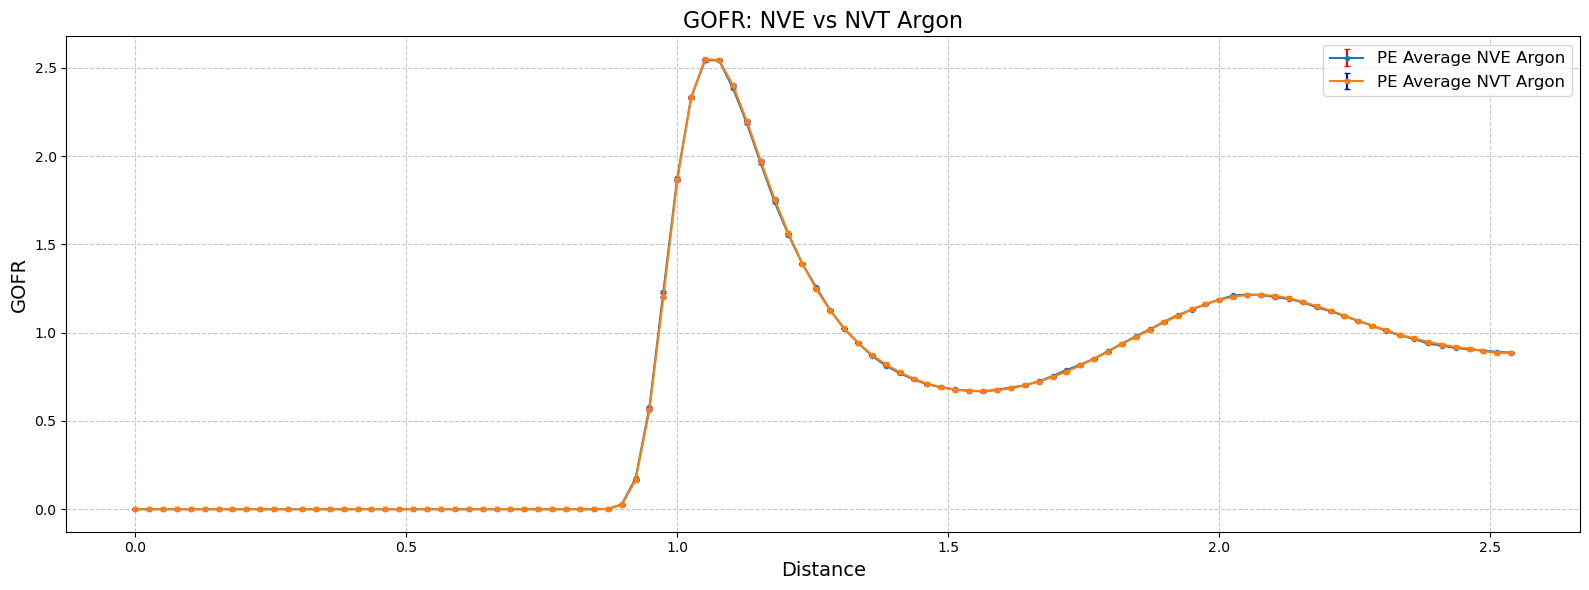

In [139]:
# File 1: NVE
file_nve = "/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVEARGON/gofr.dat"
df_nve = pd.read_csv(file_nve, delim_whitespace=True, comment="#", header=None)
df_nve.columns = ["Distance", "AVE_GOFR", "ERROR"]

# File 2: NVT Argon
file_nvt = "/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVTARGON/gofr.dat"
df_nvt = pd.read_csv(file_nvt, delim_whitespace=True, comment="#", header=None)
df_nvt.columns = ["Distance", "AVE_GOFR", "ERROR"]

# Grafico con barre di errore per entrambi i dataset
plt.figure(figsize=(16,6))

plt.errorbar(df_nve["Distance"], df_nve["AVE_GOFR"], yerr=df_nve["ERROR"],
             fmt='-o', markersize=3, linewidth=1.5, ecolor='red', capsize=2, label="PE Average NVE Argon")

plt.errorbar(df_nvt["Distance"], df_nvt["AVE_GOFR"], yerr=df_nvt["ERROR"],
             fmt='-s', markersize=3, linewidth=1.5, ecolor='blue', capsize=2, label="PE Average NVT Argon")

plt.xlabel("Distance", fontsize=14)
plt.ylabel("GOFR", fontsize=14)
plt.title("GOFR: NVE vs NVT Argon", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Difference in the distribution

/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/625733558.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nve = pd.read_csv(file_nve, delim_whitespace=True, comment="#", header=None)
/var/folders/82/8n01sj9x33b3lvjlcvfhrcc40000gn/T/ipykernel_3037/625733558.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nvt = pd.read_csv(file_nvt, delim_whitespace=True, comment="#", header=None)


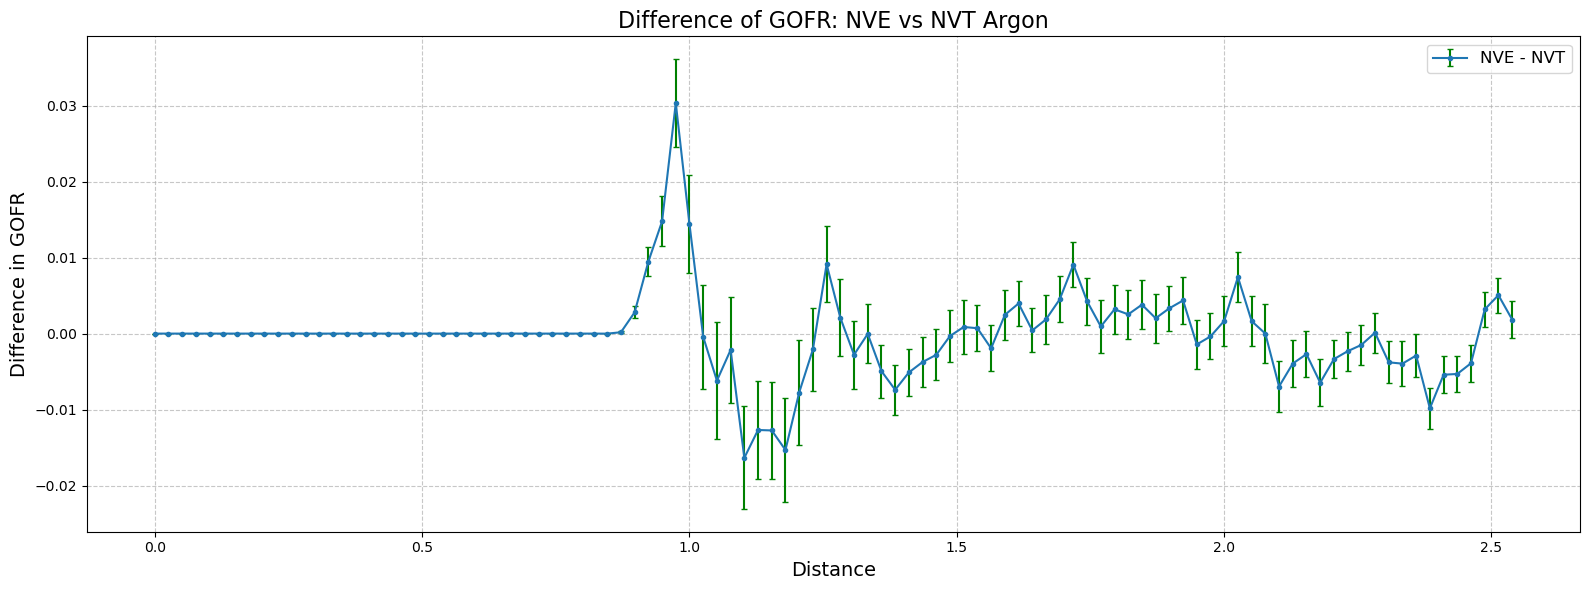

In [138]:
# File 1: NVE
file_nve = "/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVEARGON/gofr.dat"
df_nve = pd.read_csv(file_nve, delim_whitespace=True, comment="#", header=None)
df_nve.columns = ["Distance", "AVE_GOFR", "ERROR"]

# File 2: NVT Argon
file_nvt = "/Users/marta/Documents/LSN/07/NSL_SIMULATOR/OUTPUT_NVTARGON/gofr.dat"
df_nvt = pd.read_csv(file_nvt, delim_whitespace=True, comment="#", header=None)
df_nvt.columns = ["Distance", "AVE_GOFR", "ERROR"]

# Assicurarsi che le distanze coincidano (altrimenti interpolare)
assert np.allclose(df_nve["Distance"], df_nvt["Distance"]), "Le distanze non coincidono!"

# Differenza e errore propagato
diff = df_nve["AVE_GOFR"] - df_nvt["AVE_GOFR"]
diff_error = np.sqrt(df_nve["ERROR"]**2 + df_nvt["ERROR"]**2)

# Grafico della differenza
plt.figure(figsize=(16,6))
plt.errorbar(df_nve["Distance"], diff, yerr=diff_error,
             fmt='-o', markersize=3, linewidth=1.5, ecolor='green', capsize=2, label="NVE - NVT")

plt.xlabel("Distance", fontsize=14)
plt.ylabel("Difference in GOFR", fontsize=14)
plt.title("Difference of GOFR: NVE vs NVT Argon", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The two simulation methodologies do not produce compatible data. In fact, they differ by more than 2σ. This is precisely caused by the different simulation methods.
* In NVE the temperature is an “emergent” property from the initial momenta, while in NVT (MC) the temperature is imposed. If the average temperature in NVE ≠ the target temperature in MC, $U$ and $P$ will differ.
* The calculation of pressure is completely different: in MD the particles actually *move*, while in a Monte Carlo simulation they do not.

To obtain compatible simulations in terms of pressure and potential energy, it is necessary to fine-tune the parameters, trying to match the Verlet time step with the Monte Carlo displacement length.
 